In [1]:
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from rasterio.plot import reshape_as_image
from tqdm import tqdm

import numpy as np
import progressbar
import pandas as pd
import torch
import xarray as xr

from data.satellite import SatelliteData, BANDS_WITH_NO_AIR, RGB_BANDS, Normalization

%matplotlib inline 

Band info for reference: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

## Load test data

In [2]:
kwargs = {
    "data_root": "../Arizona-processed4",
    "seq_len": 60,
    "bands_to_keep": BANDS_WITH_NO_AIR,
    "use_cache": False,
}

test_data_z = SatelliteData(train=False, **kwargs, normalization=Normalization.Z)
test_data_minmax = SatelliteData(train=False, **kwargs, normalization=Normalization.MINMAX)
test_data_unnormalized = SatelliteData(train=False, normalization=Normalization.SKIP, **kwargs)
test_data_clipped5 = SatelliteData(train=False, **kwargs, normalization=Normalization.CLIP5_MINMAX)
test_data_clipped4 = SatelliteData(train=False, **kwargs, normalization=Normalization.CLIP4_MINMAX)
test_data_clipped3 = SatelliteData(train=False, **kwargs, normalization=Normalization.CLIP3_MINMAX)

Using: 556 for testing
Using: 556 for testing
Using: 556 for testing
Using: 556 for testing
Using: 556 for testing
Using: 556 for testing


In [3]:
def check_data(tile, month=7, for_viewing=True):
    tile_np = tile.numpy()
    print(f"Mean: {tile_np.mean()}\nMax: {tile_np.max()}\nMin: {tile_np.min()}\nSTD: {tile_np.std()}")
    
    # Visualize image as test
    if for_viewing:
        img = test_data_unnormalized.for_viewing(tile_np[month])
    else:
        img = tile_np[month]
    
    plt.imshow(reshape_as_image(img))
    plt.show()

Mean: 0.22674199311835666
Max: 0.8221
Min: -0.1963867514218802
STD: 0.10172539252458089


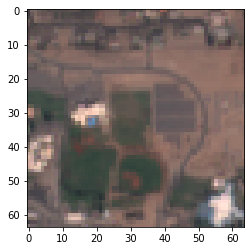

In [4]:
check_data(test_data_unnormalized[2])

## Baseline - utility code

In [ ]:
loaded_test_data = np.array([t.numpy() for t in tqdm(test_data_unnormalized)])

 95%|█████████▌| 529/556 [00:46<00:02, 11.78it/s]

In [6]:
def compute_mse(loaded_test_data, forecast_months=7, baseline_type="all_years"):
    """
    Computes mean squared error
    """
    total_mse_per_bands = 0

    for test_inst in tqdm(loaded_test_data):
        
        s = test_inst.shape
        test_inst_by_year = test_inst.reshape(-1, 12, s[1], s[2], s[3])

        # Set y to be latest 7 months
        Y_true = test_inst_by_year[-1][-forecast_months:]
        
        if baseline_type == "all_years":
            # Set y pred to be average of all past year's 7 months
            Y_pred = test_inst_by_year[:-1].mean(axis=0)[-forecast_months:]
        elif baseline_type == "last_year":
            # Set y pred to be last year's 7 months
            Y_pred = test_inst_by_year[-2][-forecast_months:]
        elif baseline_type == "last_month":
            Y_pred = test_inst_by_year[-1][-(forecast_months+1)]
        else:
            raise ValueError("baseline_type must be 'all_years', 'last_year', or 'last_month'")
        
        # Calculate mean squared loss per band
        total_mse_per_bands += ((Y_true - Y_pred)**2).mean(axis=(0,-2,-1))
        
    mean_mse_per_bands = total_mse_per_bands / len(loaded_test_data)
        
    return mean_mse_per_bands

In [22]:
def plot_mses(mses, title):
    df = pd.DataFrame(mses)
    df = df.set_index(pd.Index(test_data_unnormalized.bands_to_keep))
    df = df[df.index != "NDVI"]
    df.plot(kind='bar', figsize=(15,5), 
            title=title,
           xlabel="Band",
           ylabel="MSE");

100%|██████████| 556/556 [00:02<00:00, 223.56it/s]


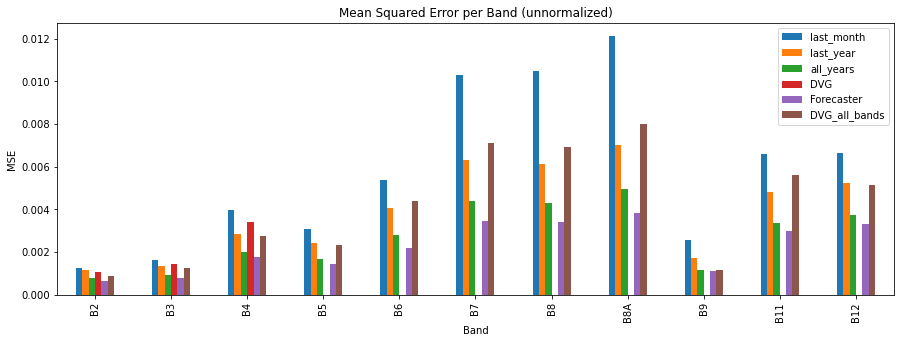

In [23]:
mses = {
    k: compute_mse(loaded_test_data, baseline_type=k)
    for k in ["last_month", "last_year", "all_years"]
}

mses["DVG"] = [0.00107829, 0.00145277, 0.0034245] + [0 for i in range(9)]
mses["Forecaster"] = [0.0006624 , 0.00078724, 0.00176056, 0.00143343, 0.00217967,
       0.00343515, 0.00342518, 0.0038342 , 0.00111316, 0.00296902,
       0.00329455, 0.02077617]

mses["DVG_all_bands"] = [#0.0006845055495803213, Don't include B1
                0.0008893806700319805,
                0.0012731088529349306,
                0.0027665143017116256,
                0.0023176277330210627,
                0.004395468719981044,
                0.007103412859175266,
                0.0069412210907184285,
                0.008013138891879192,
                0.0011411011577793448,
                #8.657123631574166e-05, Don't include B10
                0.005588778481962952,
                0.005153912937139034,
                0.031185691694902366]

plot_mses(mses, title="Mean Squared Error per Band (unnormalized)")